## Mental Health in Tech
#### Dataset from <a href='https://www.kaggle.com/osmi/mental-health-in-tech-survey'>Kaggle.com</a> and survey conducted by Open Sourcing Mental Illness, LTD.
<br />
Only recently did I learn they conduct this type of survey each year. After looking through the raw data, it became clear I would not have enough time to map all of the different columns accurately enough to include multiple years of data. The data used in this project is from 2014 and one of their largest since that time with over 1200 observations.
<br />
The objective is a proof of concept showing the likelihood of employees taking advantage of mental benefits. The methodology can be reimagined for other areas like physical health benefits, vacation programs, etc, to minimize wasted resources putting together a program which goes largely unused.

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from sklearn.metrics import roc_auc_score, plot_roc_curve

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [2]:
# Define path to data
data_path = 'mental_health_survey_233.csv'

# Import the data
df = pd.read_csv(data_path, index_col = 0)

# Convert 'timestamp' column to pandas datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format = True)

# Increase number of displayed columns,
pd.options.display.max_columns = 50

In [3]:
def split_data(df, target):

    '''
    Splits data into train, validation, and test sets.
    Validation sets can be turned off for use with
    cross validation.
    ==================================================
    
    Parameters
    ----------
    df : Data as pandas dataframe.
    val : Boolean indicating whether to split data into an extra
          validation set. Default of 'True' assumes cross validation
          is not used.
    '''


    # Separate features from target
    Features = df.drop(target, axis = 1)
    target = df[target]

    # Split data into train, validation, and test sets.
    X_train, X_val, y_train, y_val = train_test_split(Features, target, test_size = .2)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = .2)

    # Print shapes of each set for verification
    print('Train\n', X_train.shape, y_train.shape)
    print('\nValidation\n', X_val.shape, y_val.shape)
    print('\nTest\n', X_test.shape, y_test.shape)


    # Return split data
    return X_train, X_val, X_test, y_train, y_val, y_test    

In [4]:
def prep(X, y):

    '''
    Prepares data for pipeline by recoding company attribute
    columns to numeric values indicating actual value of value.
    ===========================================================

    Parameters
    ----------
    X : Feature matrix as pandas dataframe.
    y : Target vector as pandas series.
    '''

    # Drop comments column due to high null values.
    # Drop gender column.
    X = X.drop(['comments', 'gender'], axis = 1)

    # Change 'Don't know' value in 'leave' column to '2' in order to mitigate
    # overlap with scoring loop.
    X['leave'].replace('Don\'t know', 2)


    # Recode each value with a number. Each point system should be centered around 
    # answers similar to 'Don't Know' or 'Maybe'. The answers 'No' or 'Very difficult'
    # would be less than nominal while answers 'Yes' or 'Very Easy' would be higher.

    # Create lists of answers which fit each of five values for use in replacing current 
    # values within each column. Each value will be worth 0 to 4 points.

    zero_points = ['No', 'Very difficult']
    one_point = ['Don\'t know', 'Not sure', 'Somewhat difficult', 'Maybe', 'Some of them']
    two_points = ['Yes']
    three_points = ['Somewhat easy']
    four_points = ['Very easy']

    # Create list of lists for looping.
    point_lists = [zero_points, one_point, two_points, three_points, four_points]


    # Get columns as a list.
    point_columns = [i for i in X.columns[12:-1]]

    # Loop through columns to be converted to point system.
    for i in point_columns:
        # Loop through list of point lists.
        for j in range(0, len(point_lists), 1):
            
            # Replace values in each column with corresponding
            # value of the point list the value is in.
            X[i] = X[i].replace(point_lists[j], j)


    # Create new column called sentiment. This column will be a score based
    # on the sum of the points created for each company's attributes.
    X['sentiment'] = X[point_columns].sum(axis = 1)


    # Convert 'timestamp' column to pandas datetime object
    # if not already dropped.
    time_stamp = 'timestamp' in X.columns

    if time_stamp == True:
        X['timestamp'] = pd.to_datetime(X['timestamp'], infer_datetime_format = True)

    # Create columns for 'month', 'day', and 'hour'.
        X['month'] = X['timestamp'].dt.month
        X['day'] = X['timestamp'].dt.day
        X['hour'] = X['timestamp'].dt.hour

    # Drop 'timestamp' as it is no longer needed.
        X = X.drop('timestamp', axis = 1)


    # Turn target into binary category by reclassifying the 'Some of them'
    # value to 'Yes'.
    y = y.replace('Some of them', 'Yes')

    # Change target from 'Yes' and 'No' to 1 and 0.
    y = y.replace('Yes', 1).replace('No', 0)


    # Return feature matrix and target vector
    return X, y

In [5]:
def usa_split(X, y):
    '''
    Merge target vector with feature matrix. Then split
    feature matrix into observations from USA
    and observations from abroad. Return data
    as two pandas dataframes.
    ================================================
    Parameters
    ----------
    X : Feature matrix as pandas dataframe.
    y : Target vector as pandas series.
    '''

    # Merge target with features for splitting by country
    X = pd.merge(
        left = X,
        right = y,
        how = 'inner',
        left_index = True,
        right_index = True
    )

    # Split data into observations from United States
    # and those which are not.
    usa = X[X['usa'] == True]
    abroad = X[X['usa'] == False]

    return usa, abroad

In [6]:
def score(X, y, model, baseline = False):

    '''
    Calculates baseline roc auc score for comparison against
    predictions. Scores the model using roc auc metric,
    plots roc auc curve, and returns the baseline during the
    saving process.
    ===========================================================

    Paramters
    ---------
    X : Feature matrix as pandas dataframe.
    y : Target vector as pandas series.
    model : Trained tree based model compatible with sklearn.
    baseline : Either 'True' to get and save the baseline score
               or the baseline score as float.
    '''

    # Calculate roc auc score
    y_mean = y_train.value_counts(normalize = True).max()
    y_mean_series = [y_mean] * len(y_train)

    # Get the probabilities for the target vector
    y_pred = model.predict_proba(X)[:, 1]
    score = roc_auc_score(y, y_pred)


    # Plot the ROC curve.
    plot_roc_curve(model, X, y)


    # Save the baseline if baseline set to 'True',
    # print the ROC AUC score, and return the baseline
    # score.
    if baseline == True:
        baseline = score
        print('Baseline ROC AUC Score: ', score)
        return baseline

    # If the baseline has already been saved and then
    # passed here as float, print baseline, score,
    # and gain over baseline.
    elif isinstance(baseline, float):
        print('ROC AUC Baseline: ', baseline)
        print('ROC AUC Score: ', score)
        print('Gain Over Baseline: ', score - baseline)



In [7]:
# Look at data
print(df.shape)
df.head()

(1256, 27)


,timestamp,age,gender,country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37.0,female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,1,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44.0,male,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,0,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32.0,male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,1,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31.0,male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,0,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31.0,male,United States,TX,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,1,Yes,Yes,Don't know,No,NaN


In [8]:
# Unpack results from the data split function into
# a list of each dataframe. The order of the list
# is Train, Validate, Test with the 3 feature matrices
# coming before the target vectors.
target = 'treatment'
data_list = []
*data_list, = split_data(df, target)
data_list

Train
 (803, 26) (803,)

Validation
 (252, 26) (252,)

Test
 (201, 26) (201,)


[              timestamp   age  gender         country state self_employed  \
 926 2014-08-28 21:27:19  43.0    male   United States   NaN            No   
 886 2014-08-28 17:28:46  31.0    male  United Kingdom   NaN            No   
 251 2014-08-27 13:40:58  28.0    male   United States    GA            No   
 6   2014-08-27 11:31:50  35.0  female   United States    MI           NaN   
 891 2014-08-28 17:34:30  32.0    male   United States    TN           Yes   
 ..                  ...   ...     ...             ...   ...           ...   
 815 2014-08-28 14:31:00  39.0  female   United States    WA            No   
 237 2014-08-27 13:29:45  34.0    male  United Kingdom   NaN            No   
 936 2014-08-28 22:22:39  42.0    male   United States    TX            No   
 733 2014-08-28 10:34:01  31.0    male   United States    KY            No   
 498 2014-08-27 16:28:20  54.0    male  United Kingdom   NaN            No   
 
     family_history work_interfere    no_employees remote_work

In [9]:
# Extract training data from data list
X_train = data_list[0]
y_train = data_list[-3]

# Prepare the training data for the pipeline
X_train, y_train = prep(X_train, y_train)

In [10]:
# Instantiate pipeline with encoder, imputer,
# and logistic regression to get a baseline score.
log_reg = make_pipeline(
    OrdinalEncoder(handle_missing = np.NaN),
    SimpleImputer(strategy = 'mean'),
    LogisticRegression(
        max_iter = 2000
    )
)

Baseline ROC AUC Score:  0.7664750110570545


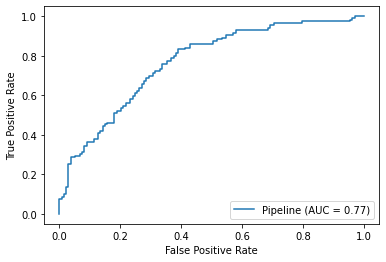

In [11]:
# Fit the model on the training data
log_reg.fit(X_train, y_train)

# Extract validation data
X_val = data_list[1]
y_val = data_list[-2]

# Prepare validation data for pipeline
X_val, y_val = prep(X_val, y_val)

# Get baseline roc auc score from scoring function and plot roc curve
baseline = score(X_val, y_val, log_reg, True)

In [12]:
# Load coefficients in pandas series and look at the sorted values
coefs = pd.Series(log_reg[-1].coef_[0], index = X_train.columns)

# Look at the sorted feature importances
coefs.sort_values(ascending = False)

obs_consequence              0.644110
care_options                 0.532209
coworkers                    0.335198
mental_health_consequence    0.258193
anonymity                    0.240168
remote_work                  0.143207
self_employed                0.127747
sentiment                    0.060211
mental_health_interview      0.024478
no_employees                 0.023635
hour                         0.004350
age                          0.003298
state                       -0.005303
day                         -0.014385
country                     -0.023503
wellness_program            -0.033748
phys_health_interview       -0.035624
tech_company                -0.079637
supervisor                  -0.114391
mental_vs_physical          -0.120639
phys_health_consequence     -0.128017
leave                       -0.177155
month                       -0.187003
seek_help                   -0.188251
benefits                    -0.249114
work_interfere              -0.370605
family_histo

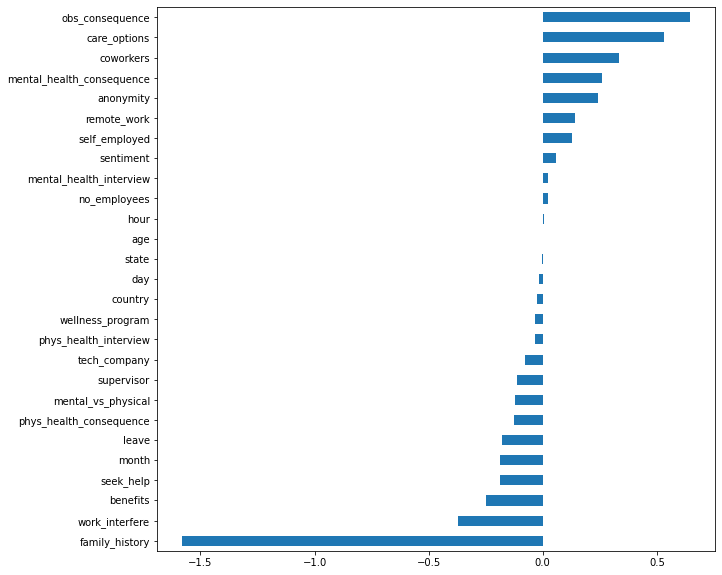

In [13]:
# Plot coefficients
coefs.sort_values().plot(kind = 'barh', figsize = (10,10));

In [14]:
# Keep only features with a coefficient absolute value of .01 or higher
coefs = coefs[abs(coefs) >= 0.0]
coefs.sort_values(ascending = False)

obs_consequence              0.644110
care_options                 0.532209
coworkers                    0.335198
mental_health_consequence    0.258193
anonymity                    0.240168
remote_work                  0.143207
self_employed                0.127747
sentiment                    0.060211
mental_health_interview      0.024478
no_employees                 0.023635
hour                         0.004350
age                          0.003298
state                       -0.005303
day                         -0.014385
country                     -0.023503
wellness_program            -0.033748
phys_health_interview       -0.035624
tech_company                -0.079637
supervisor                  -0.114391
mental_vs_physical          -0.120639
phys_health_consequence     -0.128017
leave                       -0.177155
month                       -0.187003
seek_help                   -0.188251
benefits                    -0.249114
work_interfere              -0.370605
family_histo

In [15]:
# Assign the new list of features to variable 'features'
features = [i for i in coefs.index if i in X_train.columns]

In [16]:
# Instantiate new pipeline with encoder, imputer,
# and random forest to get a baseline score.
log_reg = make_pipeline(
    OrdinalEncoder(handle_missing = np.NaN),
    SimpleImputer(strategy = 'mean'),
    LogisticRegression()
)

log_reg.fit(X_train[features], y_train)

C:\Python36\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['country', 'state', 'self_employed',
                                      'family_history', 'work_interfere',
                                      'no_employees', 'remote_work',
                                      'tech_company', 'benefits',
                                      'care_options', 'obs_consequence'],
                                handle_missing=nan,
                                mapping=[{'col': 'country',
                                          'data_type': dtype('O'),
                                          'mapping': United States      1
United Kingdom     2
Belgium            3
Ireland            4
Denmark            5
Italy              6
Isr...
                                          'mapping': No     1
Yes    2
dtype: int64},
                                         {'col': 'benefits',
                                          'data_type': dtype('O'),
                            

ROC AUC Baseline:  0.7664750110570545
ROC AUC Score:  0.7634422189928604
Gain Over Baseline:  -0.0030327920641941564


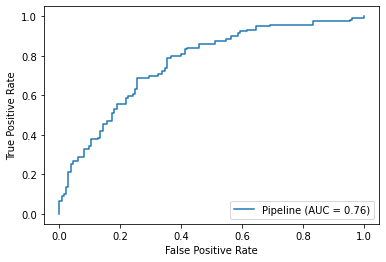

In [17]:
# Get new validation score
score(X_val[features], y_val, log_reg, baseline)

In [18]:
# Instantiate new encoder for XGBoost
encoder = OrdinalEncoder(
    handle_missing = np.NaN,
    return_df = True
)

X_train_enc = encoder.fit_transform(X_train)

In [19]:
# Set number of rounds for model
model = xgb.XGBRFClassifier(
    n_estimators = 300,
    max_depth = 4,
    scale_pos_weight = 10,
    colsample_bylayer = .3,
    colsample_bytree = .2,
    gamma = 3,
    base_score = baseline
)

# Train the model
model.fit(X_train_enc, y_train)

[12:37:26] WARNING: D:\Build\xgboost\xgboost-1.2.1.git\src\learner.cc:516: 
Parameters: { colsample_bylayer } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRFClassifier(base_score=0.7664750110570545, booster='gbtree',
                colsample_bylayer=0.3, colsample_bylevel=1,
                colsample_bytree=0.2, gamma=3, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=300, n_jobs=0,
                num_parallel_tree=300, objective='binary:logistic',
                random_state=0, reg_alpha=0, scale_pos_weight=10,
                tree_method='exact', validate_parameters=1, verbosity=None)

ROC AUC Baseline:  0.7664750110570545
ROC AUC Score:  0.9346991991059788
Gain Over Baseline:  0.16822418804892425


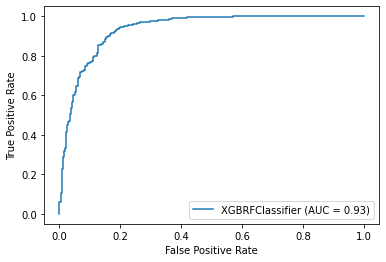

In [20]:
score(X_train_enc, y_train, model, baseline)

ROC AUC Baseline:  0.7664750110570545
ROC AUC Score:  0.8551841789347319
Gain Over Baseline:  0.08870916787767735


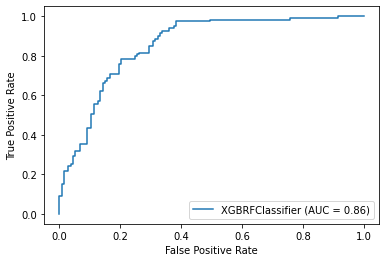

In [21]:
# Encode validation data
X_val_enc = encoder.transform(X_val)

# Get the ROC AUC score and plot the curve
score(X_val_enc, y_val, model, baseline)

In [22]:
# Get and display feature importances in descending order.
feat_imps = pd.Series(model.feature_importances_, index = X_train_enc.columns)
feat_imps.sort_values(ascending = False)

work_interfere               0.402226
family_history               0.133780
care_options                 0.049946
obs_consequence              0.029507
benefits                     0.027916
country                      0.026838
leave                        0.021526
anonymity                    0.020458
self_employed                0.020287
day                          0.019617
mental_health_consequence    0.018642
age                          0.018445
phys_health_consequence      0.017950
mental_vs_physical           0.017015
state                        0.016454
hour                         0.015849
sentiment                    0.015633
coworkers                    0.015478
supervisor                   0.015065
phys_health_interview        0.014804
no_employees                 0.014055
seek_help                    0.013896
month                        0.011637
tech_company                 0.011473
wellness_program             0.011407
mental_health_interview      0.010789
remote_work 

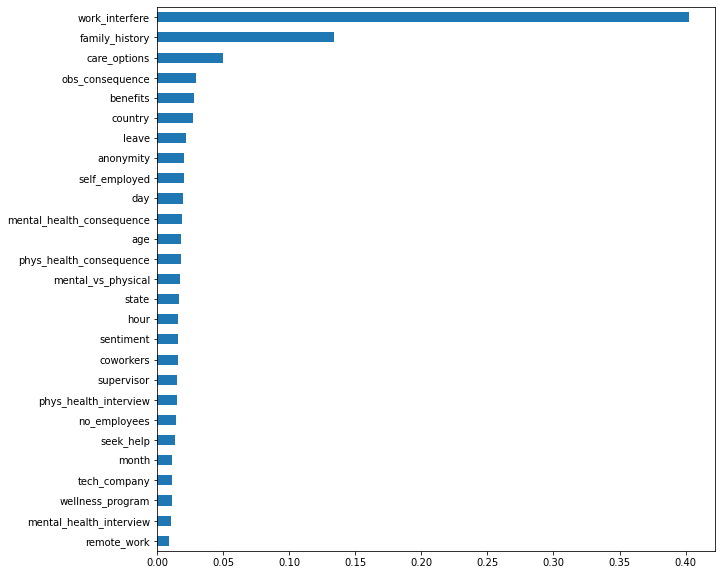

In [23]:
# Plot feature importances
feat_imps.sort_values().plot(kind = 'barh', figsize = (10,10));

In [24]:
# Assign any feature with little influence to list
drop_cols = feat_imps[feat_imps < .01].index

# Drop the unneeded features
X_train_dropped = X_train_enc.drop(drop_cols, axis = 1)

# Refit the model
model.fit(X_train_dropped, y_train)

[12:37:28] WARNING: D:\Build\xgboost\xgboost-1.2.1.git\src\learner.cc:516: 
Parameters: { colsample_bylayer } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRFClassifier(base_score=0.7664750110570545, booster='gbtree',
                colsample_bylayer=0.3, colsample_bylevel=1,
                colsample_bytree=0.2, gamma=3, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=300, n_jobs=0,
                num_parallel_tree=300, objective='binary:logistic',
                random_state=0, reg_alpha=0, scale_pos_weight=10,
                tree_method='exact', validate_parameters=1, verbosity=None)

ROC AUC Baseline:  0.7664750110570545
ROC AUC Score:  0.859859733367031
Gain Over Baseline:  0.09338472230997652


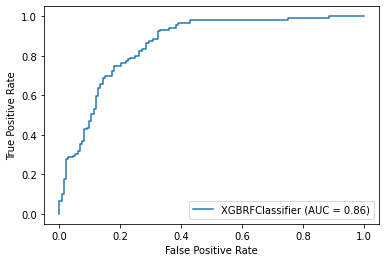

In [25]:
# Encode the validation data
X_val_enc = encoder.transform(X_val)

# Drop unneeded features
X_val_dropped = X_val_enc.drop(drop_cols, axis = 1)

# Get the validation score with the smaller feature number
score(X_val_dropped, y_val, model, baseline)

ROC AUC Baseline:  0.7664750110570545
ROC AUC Score:  0.8812636165577343
Gain Over Baseline:  0.11478860550067982


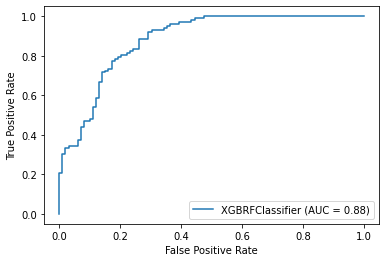

In [26]:
# Get the testing data from the data list
X_test = data_list[2]
y_test = data_list[-1]

# Prepare testing data for processing
X_test, y_test = prep(X_test, y_test)

# Encode testing data
X_test_enc = encoder.transform(X_test)

# Drop unneeded features from testing data
X_test_dropped = X_test_enc.drop(drop_cols, axis = 1)

# Get testing score for XGBRFClassifier
score(X_test_dropped, y_test, model, baseline = baseline)

In [27]:
# Split the original data to prep for visulizations
X = df.drop(target, axis = 1)
y = df[target]

# Run the prep function
df_prepped, df_y = prep(X, y)

# Reincorporate the target into the dataframe
df_prepped[target] = df_y

# Instantiate a pipeline for data visulization
trans_pipe = make_pipeline(
    OrdinalEncoder(handle_missing = np.NaN),
    SimpleImputer(strategy = 'mean'),
    StandardScaler()
)

# Encode and impute prepared data
df_clean = pd.DataFrame(
    trans_pipe[:-1].fit_transform(df_prepped),
    columns = df_prepped.columns,
    index = df_prepped.index
)

# Created a copy of encoded data and scale.
df_plot = pd.DataFrame(
    trans_pipe[-1].fit_transform(df_clean),
    columns = df_clean.columns,
    index = df_clean.index
)

In [28]:
df_clean.columns

Index(['age', 'country', 'state', 'self_employed', 'family_history',
       'work_interfere', 'no_employees', 'remote_work', 'tech_company',
       'benefits', 'care_options', 'wellness_program', 'seek_help',
       'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'sentiment', 'month', 'day',
       'hour', 'treatment'],
      dtype='object')

In [29]:
# Replace target values in df_clean with plain english
df_clean[target] = df_clean[target].replace(0, 'No').replace(1, 'Yes')

# Create the figure to hold the histogram to show people who sought
# treatment for a mental health issue by age.
fig1 = px.histogram(
    df_clean,
    x = 'age',
    y = 'work_interfere',
    color = target,
    labels = {
        'age':'Age',
        'work_interfere':'Interferes With Work',
        'treatment':'Sought Treatment'},
    title = 'Employees Seeking Treatment by Age and Work Interference',
    histfunc = 'count',
    marginal = 'violin',
    orientation = 'v'
)

# Render the histogram
fig1.show()

In [30]:
# Save chart to html file
pio.write_html(fig1, 'interferes_work.html')

In [31]:
# Replace target values in df_prepped with plain english
df_prepped[target] = df_prepped[target].replace(0, 'No').replace(1, 'Yes')

# Create the figure to hold the histogram to show people who sought
# treatment for a mental health issue by age.
fig2 = px.histogram(
    df_prepped,
    x = 'no_employees',
    y = 'obs_consequence',
    color = target,
    labels = {
        'no_employees':'Number of Employees',
        'obs_consequence':'Observed Consequences of Mental Health Issue',
        'treatment':'Sought Treatment'},
    title = 'Employees Seeking Treatment by Company Size and Negative Consequences',
    histfunc = 'count',    
    marginal = 'violin',
    orientation = 'v',
    category_orders = {
        'no_employees':['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000']
        }
)

# Render the histogram
fig2.show()


In [32]:
# Save chart to html file
pio.write_html(fig2, 'issue_consequence.html')

In [34]:

fig3 = px.histogram(
    df_prepped,
    x = 'sentiment',
    y = 'anonymity',
    color = target,
    labels = {
        'sentiment':'Sentiment Score of Employees Toward Company',
        'anonymity':'Employees Feel Anonymity is Respected',
        'treatment':'Sought Treatment'},
    title = 'Employees Seeking Treatment by Company Sentiment and Respected Anonymity',
    histfunc = 'count',    
    marginal = 'violin',
    orientation = 'v',
    category_orders = {
        'no_employees':['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000']
        }
)

# Render the histogram
fig3.show()

In [35]:
# Save chart to html file
pio.write_html(fig3, 'anonymity.html')